In [1]:
!ls

Assignment3			 Train_set_WRIST.csv
elbow_vgg16_model.pkl		 Valid_set.csv
full_model.h5			 Valid_set_ELBOW.csv
lung_opacity1_weights.best.hdf5  Valid_set_FINGER.csv
mura_bone_fracture.ipynb	 Valid_set_FOREARM.csv
muranotebook.ipynb		 Valid_set_HAND.csv
MURA-v1.1			 Valid_set_HUMERUS.csv
Train_set.csv			 Valid_set_SHOULDER.csv
Train_set_ELBOW.csv		 Valid_set_WRIST.csv
Train_set_FINGER.csv		 vgg_mura_final_hum.ipynb
Train_set_FOREARM.csv		 v_test
Train_set_HAND.csv		 v_train
Train_set_HUMERUS.csv		 v_valid
Train_set_SHOULDER.csv


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
from tensorflow.keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet169
from keras.models import Model
from keras import layers
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.applications.resnet import ResNet50
from keras.applications.resnet import decode_predictions
import cv2
import keras.backend as K

/packages/7x/anaconda3/5.3.0/envs/tf2.4.1-gpu/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
2022-11-29 16:42:55.083600: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 16:42:55.290000: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-29 16:42:55.336914

In [3]:
data_dir = 'MURA-v1.1'

train_dir = data_dir + '/train' # Path to train directory
val_dir = data_dir + '/valid' # Path to validation directory

ABNORMAL


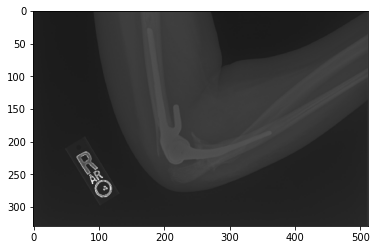

In [4]:
# Display abnormal bone image
img_abnormal = load_img('MURA-v1.1/train/XR_ELBOW/patient00069/study1_positive/image2.png')
print('ABNORMAL')
plt.imshow(img_abnormal)
plt.show()

NORMAL


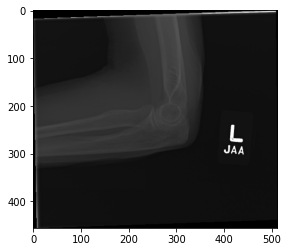

In [5]:
# Display normal bone image
img_normal = load_img('MURA-v1.1/train/XR_ELBOW/patient00011/study1_negative/image1.png')
print('NORMAL')
plt.imshow(img_normal)
plt.show()

In [6]:
# Train set studies with labels
df=pd.read_csv('MURA-v1.1/train_labeled_studies.csv', names=['Train_Image','Train_Label'])

In [7]:
df.head(20)

,Train_Image,Train_Label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1
5,MURA-v1.1/train/XR_SHOULDER/patient00006/study...,1
6,MURA-v1.1/train/XR_SHOULDER/patient00007/study...,1
7,MURA-v1.1/train/XR_SHOULDER/patient00007/study...,0
8,MURA-v1.1/train/XR_SHOULDER/patient00008/study...,1
9,MURA-v1.1/train/XR_SHOULDER/patient00009/study...,1


0    8280
1    5177
Name: Train_Label, dtype: int64


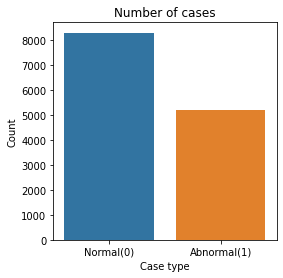

In [8]:
# Count labels in train set
cases_count = df['Train_Label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(4,4))
sns.barplot(x=cases_count.index, y=cases_count.values)
plt.title('Number of cases', fontsize=12)
plt.xlabel('Case type', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Abnormal(1)'])
plt.show()

In [9]:
# Adding labels to individual images in train set
df=pd.read_csv('MURA-v1.1/train_image_paths.csv', names=['Train_Image'])
names=df['Train_Image'].values
train_labels=[]

for i in names:
  if ('positive' in i):
    train_labels.append('1')
  elif('negative' in i):
    train_labels.append('0')

train_labels = np.array(train_labels)
#labels = pd.DataFrame(labels, columns=['Image', 'Label'])
df.insert(1, 'Train_Label', train_labels)
df.to_csv('Train_set.csv', index=False)

In [10]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [11]:
df1 = pd.DataFrame(columns = ['Train_Image', 'Train_Label'])
for index, row in df.iterrows():
  if ('WRIST' in str(row['Train_Image'])):
    df1= df1.append({'Train_Image' :  str(row['Train_Image']), 'Train_Label': str(row['Train_Label'])}, ignore_index=True)
df1.to_csv('Train_set_WRIST.csv', index=False)

/tmp/ipykernel_254799/3309552935.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1= df1.append({'Train_Image' :  str(row['Train_Image']), 'Train_Label': str(row['Train_Label'])}, ignore_index=True)
/tmp/ipykernel_254799/3309552935.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1= df1.append({'Train_Image' :  str(row['Train_Image']), 'Train_Label': str(row['Train_Label'])}, ignore_index=True)
/tmp/ipykernel_254799/3309552935.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1= df1.append({'Train_Image' :  str(row['Train_Image']), 'Train_Label': str(row['Train_Label'])}, ignore_index=True)
/tmp/ipykernel_254799/3309552935.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pand

In [12]:
df.head(20)

,Train_Image,Train_Label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
5,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
6,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
7,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
8,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
9,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1


0    21935
1    14873
Name: Train_Label, dtype: int64


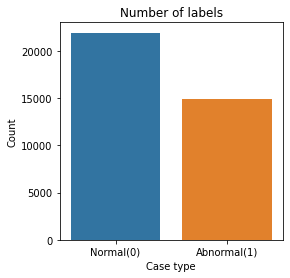

In [13]:
# Count individual number of labels of images in train set
cases_count = df['Train_Label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(4,4))
sns.barplot(x=cases_count.index, y=cases_count.values)
plt.title('Number of labels', fontsize=12)
plt.xlabel('Case type', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Abnormal(1)'])
plt.show()

In [14]:
#Validation set studies with labels
df=pd.read_csv('MURA-v1.1/valid_labeled_studies.csv', names=['Valid_Image','Valid_Label'])

In [15]:
df.head(20)

,Valid_Image,Valid_Label
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
1,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1
2,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...,1
3,MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...,1
4,MURA-v1.1/valid/XR_WRIST/patient11187/study1_p...,1
5,MURA-v1.1/valid/XR_WRIST/patient11188/study1_p...,1
6,MURA-v1.1/valid/XR_WRIST/patient11189/study1_p...,1
7,MURA-v1.1/valid/XR_WRIST/patient11190/study1_p...,1
8,MURA-v1.1/valid/XR_WRIST/patient11191/study1_p...,1
9,MURA-v1.1/valid/XR_WRIST/patient11192/study1_p...,1


0    661
1    538
Name: Valid_Label, dtype: int64


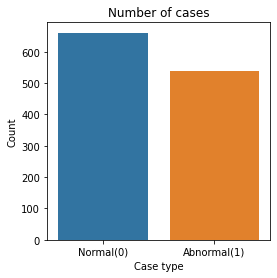

In [16]:
# Count labels in validation set
cases_count = df['Valid_Label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(4,4))
sns.barplot(x=cases_count.index, y=cases_count.values)
plt.title('Number of cases', fontsize=12)
plt.xlabel('Case type', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Abnormal(1)'])
plt.show()

In [17]:
# Adding labels to individual images in validation set
df=pd.read_csv('MURA-v1.1/valid_image_paths.csv', names=['Valid_Image'])
names=df['Valid_Image'].values
valid_labels=[]

for i in names:
  if ('positive' in i):
    valid_labels.append('1')
  elif('negative' in i):
    valid_labels.append('0')

valid_labels = np.array(valid_labels)
#labels = pd.DataFrame(labels, columns=['Image', 'Label'])
df.insert(1, 'Valid_Label', valid_labels)
df.to_csv('Valid_set.csv', index=False)

In [18]:
df.head(20)
df1 = pd.DataFrame(columns = ['Valid_Image', 'Valid_Label'])
for index, row in df.iterrows():
  if ('WRIST' in str(row['Valid_Image'])):
    df1= df1.append({'Valid_Image' :  str(row['Valid_Image']), 'Valid_Label': str(row['Valid_Label'])}, ignore_index=True)
df1.to_csv('Valid_set_WRIST.csv', index=False)

/tmp/ipykernel_254799/444348761.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1= df1.append({'Valid_Image' :  str(row['Valid_Image']), 'Valid_Label': str(row['Valid_Label'])}, ignore_index=True)
/tmp/ipykernel_254799/444348761.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1= df1.append({'Valid_Image' :  str(row['Valid_Image']), 'Valid_Label': str(row['Valid_Label'])}, ignore_index=True)
/tmp/ipykernel_254799/444348761.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1= df1.append({'Valid_Image' :  str(row['Valid_Image']), 'Valid_Label': str(row['Valid_Label'])}, ignore_index=True)
/tmp/ipykernel_254799/444348761.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

In [19]:
df.head(20)

,Valid_Image,Valid_Label
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1
5,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1
6,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...,1
7,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...,1
8,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...,1
9,MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...,1


0    1667
1    1530
Name: Valid_Label, dtype: int64


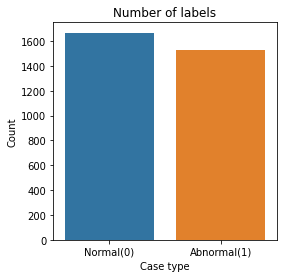

In [20]:
# Count individual number of labels of images in validation set
cases_count = df['Valid_Label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(4,4))
sns.barplot(x=cases_count.index, y=cases_count.values)
plt.title('Number of labels', fontsize=12)
plt.xlabel('Case type', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Abnormal(1)'])
plt.show()

In [21]:
# Read Training and Validation .csv files
train_df = pd.read_csv("./Train_set_HUMERUS.csv", dtype=str)
valid_df = pd.read_csv("./Valid_set_HUMERUS.csv", dtype=str)

datagen = ImageDataGenerator(rescale=1./255, rotation_range=30)

In [22]:
# Image Preprocessing
train_generator = datagen.flow_from_dataframe(dataframe=train_df, directory=None,
                                              x_col="Train_Image", y_col="Train_Label",
                                              target_size=(224,224), class_mode="binary",
                                              batch_size=32, shuffle=True)

valid_generator = datagen.flow_from_dataframe(dataframe=valid_df, directory=None,
                                              x_col="Valid_Image", y_col="Valid_Label",
                                              target_size=(224,224), class_mode="binary",
                                              batch_size=32, shuffle=True)

Found 1272 validated image filenames belonging to 2 classes.
Found 288 validated image filenames belonging to 2 classes.


In [23]:
# Import DenseNet169 pre-trained model
resnet_model = ResNet50(include_top=True, weights='imagenet')

2022-11-29 16:17:09.374538: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sgupt279/.local/lib/python3.8/site-packages/cv2/../../lib64:/packages/7x/anaconda3/5.3.0/lib
2022-11-29 16:17:09.374620: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-29 16:17:09.376156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI F

In [24]:
#resnet_model.summary()

In [25]:
# Pop off the last layer
resnet_model.layers.pop()

In [26]:
# Compile the model
predictions = Dense(1, activation='sigmoid')(resnet_model.layers[-1].output)
model = Model(inputs=resnet_model.input, outputs=predictions)

model.compile(optimizer = Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

/home/sgupt279/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [27]:
#model.summary()

In [28]:
# Number of train and validation steps
train_steps=train_generator.n//train_generator.batch_size
valid_steps=valid_generator.n//valid_generator.batch_size

In [29]:
filepath = "weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', save_best_only=True, verbose=1, mode='max')

In [30]:
# Fit the model
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_steps,
                    validation_data=valid_generator,
                    validation_steps=valid_steps,
                    epochs=15,
                    callbacks=[checkpoint])

/tmp/ipykernel_254799/813127691.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/15
39/39 [==============================] - 58s 1s/step - loss: 0.6843 - accuracy: 0.6847 - val_loss: 0.6932 - val_accuracy: 0.4896
Epoch 2/15
39/39 [==============================] - 44s 1s/step - loss: 0.6709 - accuracy: 0.8048 - val_loss: 0.6932 - val_accuracy: 0.4861
Epoch 3/15
39/39 [==============================] - 44s 1s/step - loss: 0.6693 - accuracy: 0.7984 - val_loss: 0.6932 - val_accuracy: 0.4861
Epoch 4/15
39/39 [==============================] - 44s 1s/step - loss: 0.6676 - accuracy: 0.7911 - val_loss: 0.6933 - val_accuracy: 0.4965
Epoch 5/15
39/39 [==============================] - 44s 1s/step - loss: 0.6636 - accuracy: 0.8258 - val_loss: 0.6933 - val_accuracy: 0.4896
Epoch 6/15
39/39 [==============================] - 44s 1s/step - loss: 0.6615 - accuracy: 0.8298 - val_loss: 0.6927 - val_accuracy: 0.5139
Epoch 7/15
39/39 [==============================] - 44s 1s/step - loss: 0.6595 - accuracy: 0.8339 - val_loss: 0.6927 - val_accuracy: 0.5139
Epoch 8/15
39/39 [==

In [31]:
!ls

Assignment3			 Train_set_WRIST.csv
elbow_vgg16_model.pkl		 Valid_set.csv
full_model.h5			 Valid_set_ELBOW.csv
lung_opacity1_weights.best.hdf5  Valid_set_FINGER.csv
mura_bone_fracture.ipynb	 Valid_set_FOREARM.csv
muranotebook.ipynb		 Valid_set_HAND.csv
MURA-v1.1			 Valid_set_HUMERUS.csv
Train_set.csv			 Valid_set_SHOULDER.csv
Train_set_ELBOW.csv		 Valid_set_WRIST.csv
Train_set_FINGER.csv		 vgg_mura_final_hum.ipynb
Train_set_FOREARM.csv		 v_test
Train_set_HAND.csv		 v_train
Train_set_HUMERUS.csv		 v_valid
Train_set_SHOULDER.csv


In [33]:
from tensorflow.keras.models import save_model
save_model(model, "cammodel.h5")

In [12]:
from tensorflow.keras.models import load_model
model = load_model('cammodel.h5')
model.summary()

2022-11-29 16:43:54.899953: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sgupt279/.local/lib/python3.8/site-packages/cv2/../../lib64:/packages/7x/anaconda3/5.3.0/lib
2022-11-29 16:43:54.899991: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-29 16:43:54.902940: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI F

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [2]:
#visualize_class_activation_map("MURA-v1.1/train/XR_ELBOW/patient00011/study1_negative/image1.png", "output_path")
original_img = cv2.imread("MURA-v1.1/train/XR_ELBOW/patient00011/study1_negative/image1.png", 1)
original_img.shape
#original_img.reshape(224,224,3)
output = cv2.resize(original_img, (224,224))

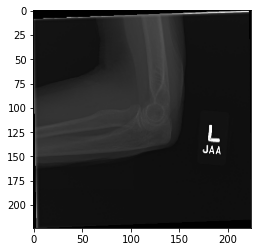

In [3]:
output.shape
output = output.reshape( 224,224,3) 
plt.imshow(output)

In [4]:
!pwd

/home/sgupt279/Desktop


In [5]:
from keras.applications.vgg16 import VGG16
import matplotlib.image as mpimg
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
K.clear_session()

In [6]:
import keras.utils as image
img = image.load_img("MURA-v1.1/train/XR_ELBOW/patient00011/study1_negative/image1.png", target_size=(224, 224))

In [7]:
x = image.img_to_array(img)

In [8]:
import numpy as np
x = np.expand_dims(x, axis=0)

In [9]:
x.shape

(1, 224, 224, 3)

In [10]:
from keras.applications.vgg16 import preprocess_input
x = preprocess_input(x)

In [13]:
import pandas as pd
from keras.applications.vgg16 import decode_predictions
preds = model.predict(x)
#predictions = pd.DataFrame(decode_predictions(preds, top=3)[0],columns=['col1','category','probability']).iloc[:,1:]
#print('PREDICTION:',predictions.loc[0,'category'])

1/1 [==============================] - 1s 1s/step


In [14]:
argmax = np.argmax(preds[0])

In [15]:
output = model.output[:, argmax]

In [17]:
last_conv_layer = model.get_layer('conv5_block3_out')

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [24]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [25]:
i = np.argmax(preds[0])

In [30]:
#for idx in range(len(model.layers)):
  #print(model.get_layer(index = idx).name)


0


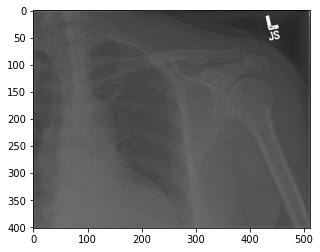

In [58]:
print(i)
icam = GradCAM(model, i, 'conv5_block3_out') 
image = cv2.imread("MURA-v1.1/train/XR_SHOULDER/patient00007/study1_positive/image2.png", 1)
plt.imshow(image)


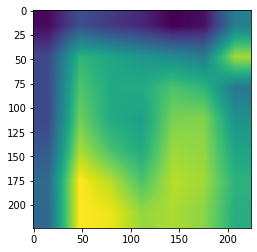

In [60]:
image.shape
#original_img.reshape(224,224,3)
image = cv2.resize(image, (224,224))
image = image.reshape( 224,224,3) 
import numpy as np
image = np.expand_dims(image, axis=0)
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (224, 224))

plt.imshow(heatmap)
image = cv2.imread("MURA-v1.1/train/XR_SHOULDER/patient00007/study1_positive/image2.png", 1)
image = cv2.resize(image, (224,224))
(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

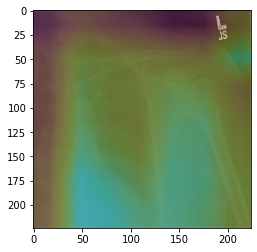

In [61]:
plt.imshow(output)